In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

C:\Users\Raghav\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Raghav\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1


In [2]:
import pandas as pd
import os

# Get all image files from the dataset path
image_data = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)
            # Extract label from directory name or filename
            label = os.path.basename(root)
            image_data.append({'image_path': full_path, 'label': label})

df = pd.DataFrame(image_data)
print(f"\nTotal images: {len(df)}")


Total images: 24998


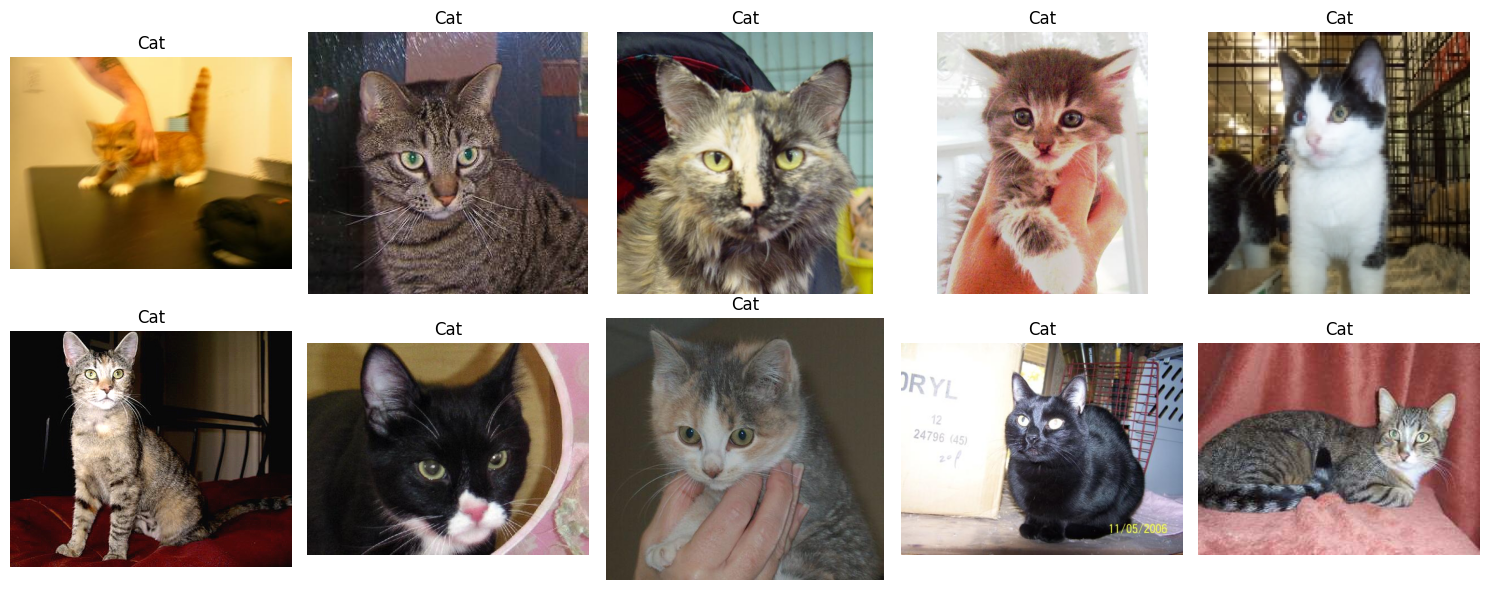


Label Distribution:
label
Cat    12499
Dog    12499
Name: count, dtype: int64


In [3]:
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

# Display sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx in range(10):
    try:
        img = Image.open(df.iloc[idx]['image_path'])
        axes[idx].imshow(img)
        axes[idx].set_title(df.iloc[idx]['label'])
        axes[idx].axis('off')
    except Exception as e:
        axes[idx].text(0.5, 0.5, f'Error loading image', ha='center', va='center')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Display label distribution
label_counts = df['label'].value_counts()
print("\nLabel Distribution:")
print(label_counts)

In [4]:
# Data Preprocessing and Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Image parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

print(f"Image dimensions: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")

Image dimensions: 150x150
Batch size: 32


In [5]:
# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")  
print(f"Test samples: {len(test_df)}")

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Training samples: 17498
Validation samples: 3750
Test samples: 3750


In [6]:
# Data Generators WITHOUT augmentation
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators WITH augmentation
train_datagen_with_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create generators for training WITHOUT augmentation
train_generator_no_aug = train_datagen_no_aug.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Create generators for training WITH augmentation
train_generator_with_aug = train_datagen_with_aug.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Validation and test generators (no augmentation)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Data generators created successfully!")
print(f"Class indices: {train_generator_no_aug.class_indices}")

Found 17498 validated image filenames belonging to 2 classes.
Found 17498 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Data generators created successfully!
Class indices: {'Cat': 0, 'Dog': 1}


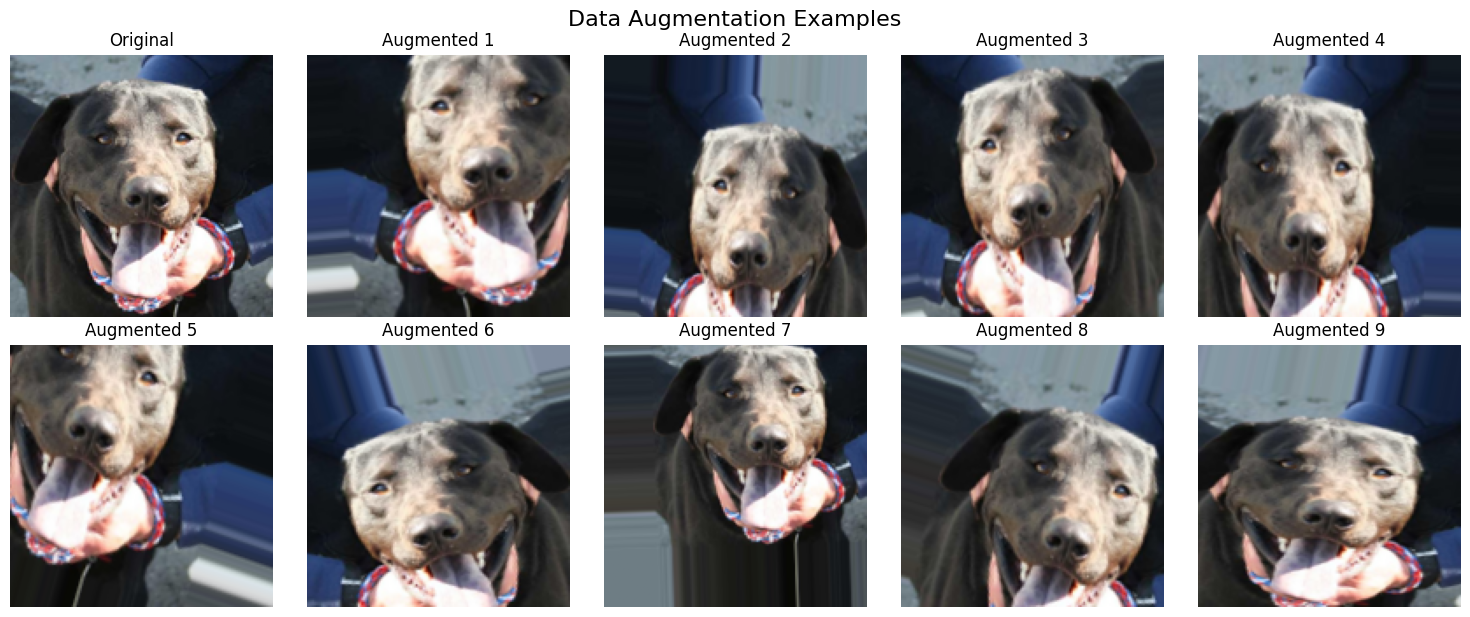

In [7]:
# Visualize Data Augmentation Effects
def visualize_augmentation():
    # Get a sample image
    sample_img = Image.open(train_df.iloc[0]['image_path'])
    sample_img = sample_img.resize((IMG_HEIGHT, IMG_WIDTH))
    sample_array = np.array(sample_img) / 255.0
    sample_array = np.expand_dims(sample_array, axis=0)
    
    # Create augmentation generator for visualization
    aug_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Generate augmented versions
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    # Show original
    axes[0].imshow(sample_array[0])
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Generate and show augmented versions
    i = 1
    for batch in aug_gen.flow(sample_array, batch_size=1):
        axes[i].imshow(batch[0])
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')
        i += 1
        if i >= 10:
            break
    
    plt.tight_layout()
    plt.suptitle('Data Augmentation Examples', y=1.02, fontsize=16)
    plt.show()

visualize_augmentation()

In [8]:
# CNN Model Architecture
def create_cnn_model():
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Fourth Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# Create and compile models
model_no_aug = create_cnn_model()
model_with_aug = create_cnn_model()

# Compile models
model_no_aug.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_with_aug.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("Model Architecture:")
model_no_aug.summary()

C:\Users\Raghav\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Training Parameters
EPOCHS = 10

# Callbacks for better training
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

callbacks = [early_stopping, reduce_lr]

In [10]:
# Train Model WITHOUT Data Augmentation
print("Training Model WITHOUT Data Augmentation...")
print("="*50)

history_no_aug = model_no_aug.fit(
    train_generator_no_aug,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining without augmentation completed!")

Training Model WITHOUT Data Augmentation...


C:\Users\Raghav\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 11/546 ━━━━━━━━━━━━━━━━━━━━ 7:41 862ms/step - accuracy: 0.4620 - loss: 0.7058

C:\Users\Raghav\AppData\Roaming\Python\Python313\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


546/546 ━━━━━━━━━━━━━━━━━━━━ 540s 986ms/step - accuracy: 0.6566 - loss: 0.6078 - val_accuracy: 0.7179 - val_loss: 0.5375 - learning_rate: 0.0010
Epoch 2/10
  1/546 ━━━━━━━━━━━━━━━━━━━━ 2:30 276ms/step - accuracy: 0.6250 - loss: 0.6650

C:\Users\Raghav\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6250 - loss: 0.6650 - val_accuracy: 0.7214 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 3/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 138s 253ms/step - accuracy: 0.7615 - loss: 0.4956 - val_accuracy: 0.7914 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 4/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5625 - loss: 0.6001 - val_accuracy: 0.7919 - val_loss: 0.4399 - learning_rate: 0.0010
Epoch 5/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 145s 266ms/step - accuracy: 0.8036 - loss: 0.4277 - val_accuracy: 0.8200 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 6/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7500 - loss: 0.3591 - val_accuracy: 0.8194 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 7/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 145s 265ms/step - accuracy: 0.8351 - loss: 0.3751 - val_accuracy: 0.8283 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 8/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.8125 - loss: 0

In [11]:
# Train Model WITH Data Augmentation
print("Training Model WITH Data Augmentation...")
print("="*50)

# Reset validation generator for consistent evaluation
val_generator.reset()

history_with_aug = model_with_aug.fit(
    train_generator_with_aug,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining with augmentation completed!")

Training Model WITH Data Augmentation...
Epoch 1/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 182s 331ms/step - accuracy: 0.5709 - loss: 0.6743 - val_accuracy: 0.5970 - val_loss: 0.6586 - learning_rate: 0.0010
Epoch 2/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4375 - loss: 0.7371 - val_accuracy: 0.6277 - val_loss: 0.6448 - learning_rate: 0.0010
Epoch 3/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 169s 309ms/step - accuracy: 0.6557 - loss: 0.6185 - val_accuracy: 0.6947 - val_loss: 0.5873 - learning_rate: 2.0000e-04

Training with augmentation completed!


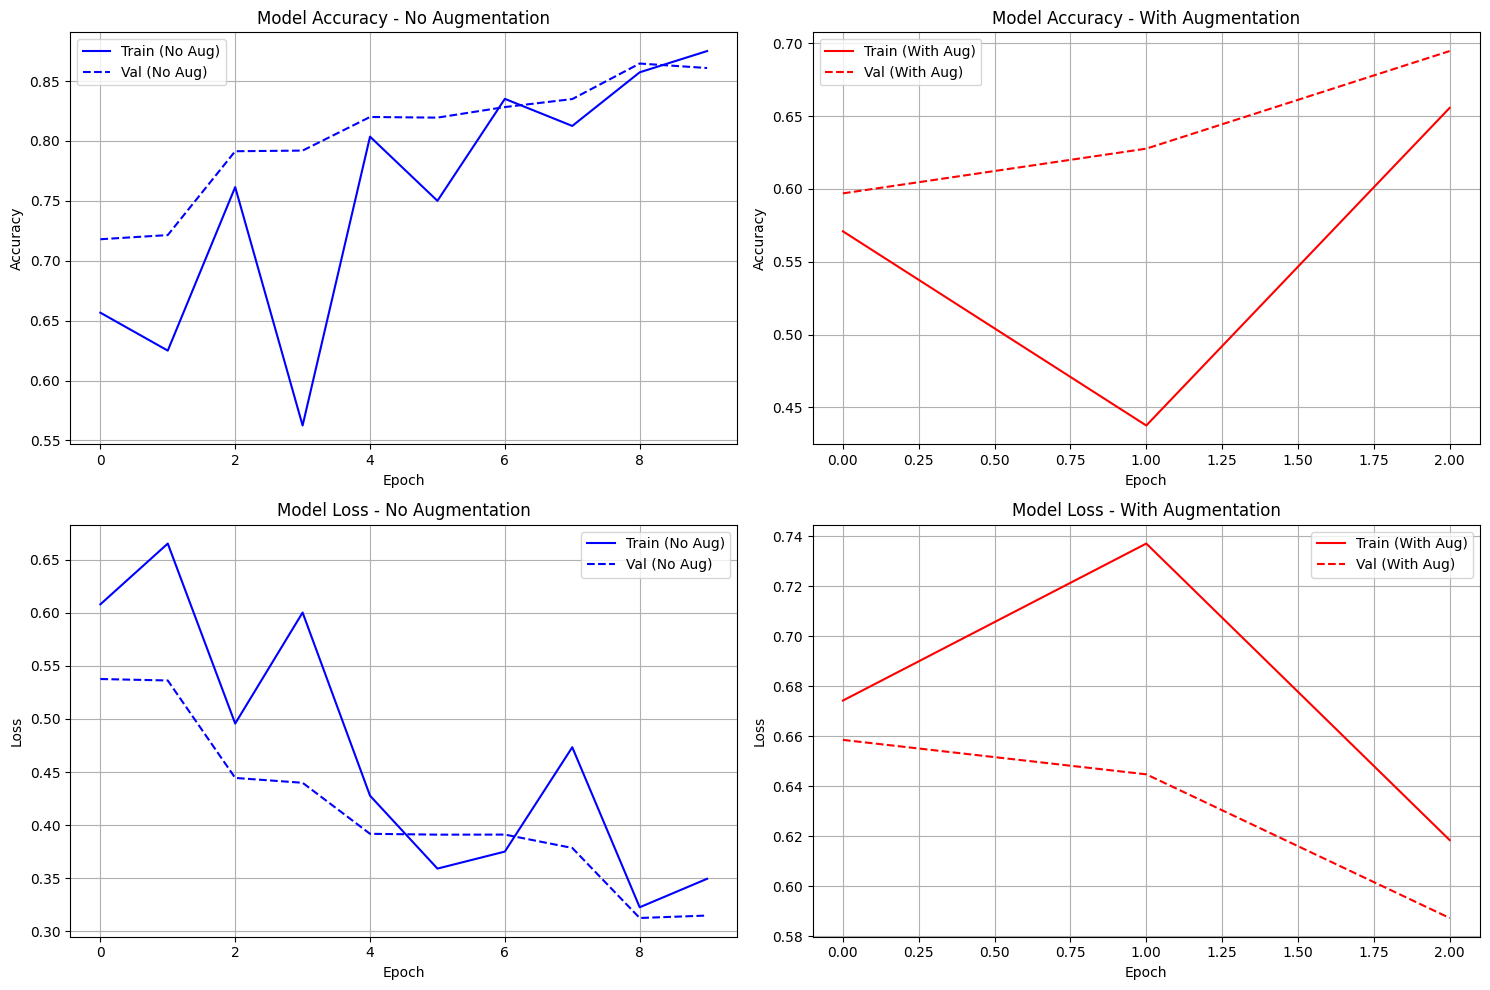

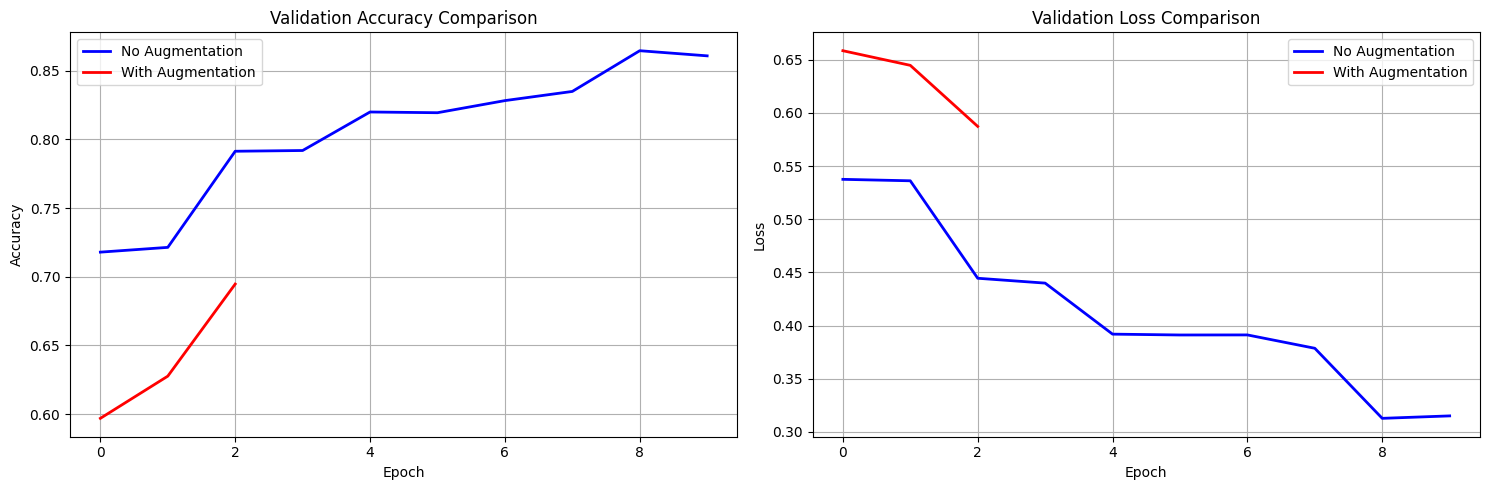

In [12]:
# Plot Training History Comparison
def plot_training_history(history_no_aug, history_with_aug):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy plots
    axes[0, 0].plot(history_no_aug.history['accuracy'], label='Train (No Aug)', color='blue')
    axes[0, 0].plot(history_no_aug.history['val_accuracy'], label='Val (No Aug)', color='blue', linestyle='--')
    axes[0, 0].set_title('Model Accuracy - No Augmentation')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(history_with_aug.history['accuracy'], label='Train (With Aug)', color='red')
    axes[0, 1].plot(history_with_aug.history['val_accuracy'], label='Val (With Aug)', color='red', linestyle='--')
    axes[0, 1].set_title('Model Accuracy - With Augmentation')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Loss plots
    axes[1, 0].plot(history_no_aug.history['loss'], label='Train (No Aug)', color='blue')
    axes[1, 0].plot(history_no_aug.history['val_loss'], label='Val (No Aug)', color='blue', linestyle='--')
    axes[1, 0].set_title('Model Loss - No Augmentation')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(history_with_aug.history['loss'], label='Train (With Aug)', color='red')
    axes[1, 1].plot(history_with_aug.history['val_loss'], label='Val (With Aug)', color='red', linestyle='--')
    axes[1, 1].set_title('Model Loss - With Augmentation')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Combined comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Combined accuracy
    ax1.plot(history_no_aug.history['val_accuracy'], label='No Augmentation', color='blue', linewidth=2)
    ax1.plot(history_with_aug.history['val_accuracy'], label='With Augmentation', color='red', linewidth=2)
    ax1.set_title('Validation Accuracy Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Combined loss
    ax2.plot(history_no_aug.history['val_loss'], label='No Augmentation', color='blue', linewidth=2)
    ax2.plot(history_with_aug.history['val_loss'], label='With Augmentation', color='red', linewidth=2)
    ax2.set_title('Validation Loss Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_no_aug, history_with_aug)

In [13]:
# Model Evaluation on Test Set
print("Evaluating Models on Test Set...")
print("="*40)

# Evaluate model without augmentation
test_loss_no_aug, test_acc_no_aug = model_no_aug.evaluate(test_generator, verbose=0)

# Reset test generator for second evaluation
test_generator.reset()

# Evaluate model with augmentation
test_loss_with_aug, test_acc_with_aug = model_with_aug.evaluate(test_generator, verbose=0)

# Display results
print(f"\nTest Results:")
print(f"{'Model':<25} {'Test Loss':<12} {'Test Accuracy':<15}")
print("="*52)
print(f"{'No Augmentation':<25} {test_loss_no_aug:<12.4f} {test_acc_no_aug:<15.4f}")
print(f"{'With Augmentation':<25} {test_loss_with_aug:<12.4f} {test_acc_with_aug:<15.4f}")

# Calculate improvement
accuracy_improvement = (test_acc_with_aug - test_acc_no_aug) * 100
print(f"\nAccuracy Improvement: {accuracy_improvement:+.2f}%")

if test_acc_with_aug > test_acc_no_aug:
    print("✅ Data augmentation improved model performance!")
else:
    print("⚠️ Data augmentation did not improve model performance in this case.")

Evaluating Models on Test Set...

Test Results:
Model                     Test Loss    Test Accuracy  
No Augmentation           0.3129       0.8669         
With Augmentation         0.6490       0.6045         

Accuracy Improvement: -26.24%
⚠️ Data augmentation did not improve model performance in this case.


Sample Predictions - Model WITHOUT Augmentation:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


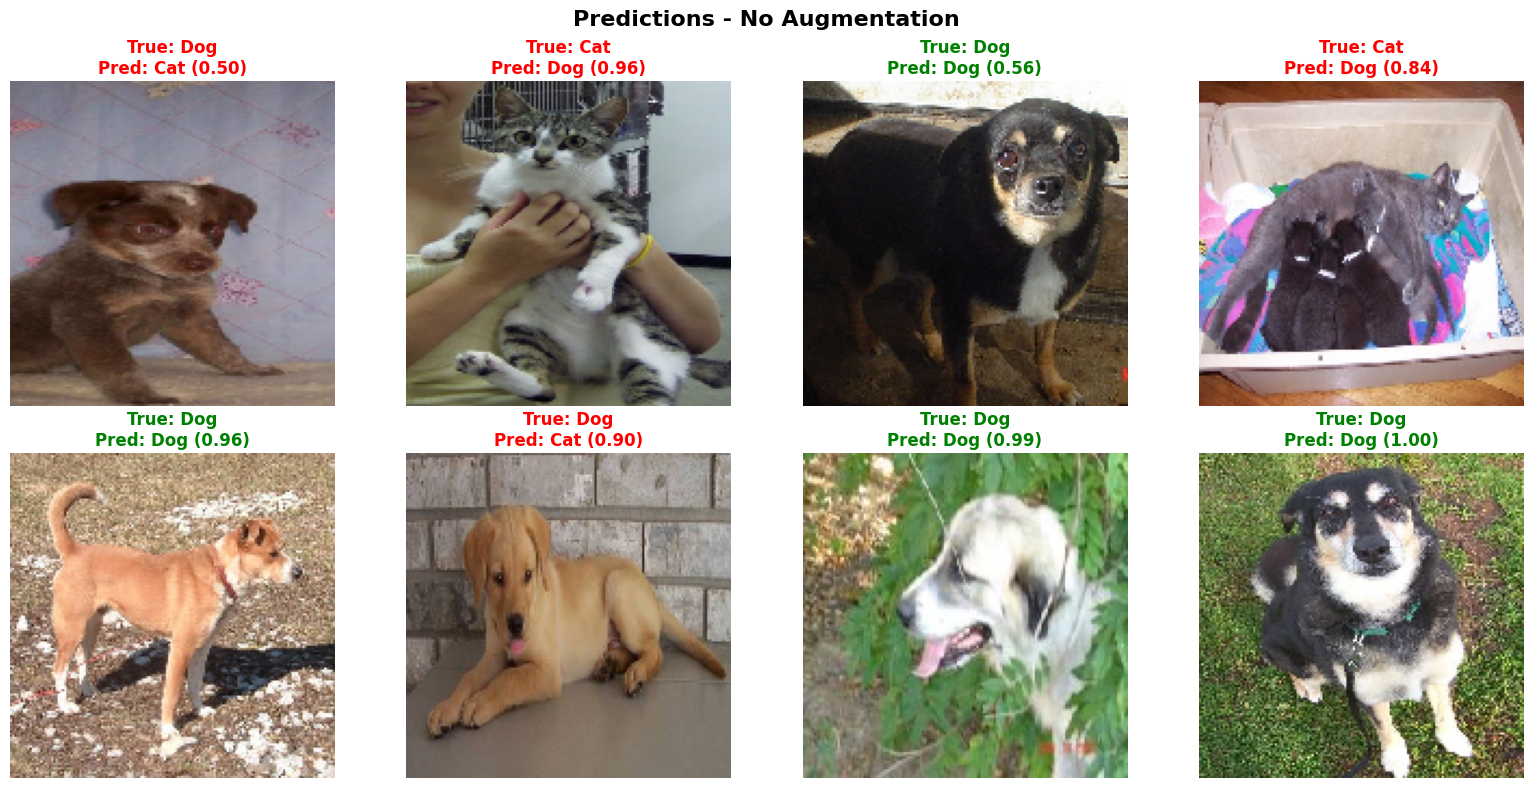


Sample Predictions - Model WITH Augmentation:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


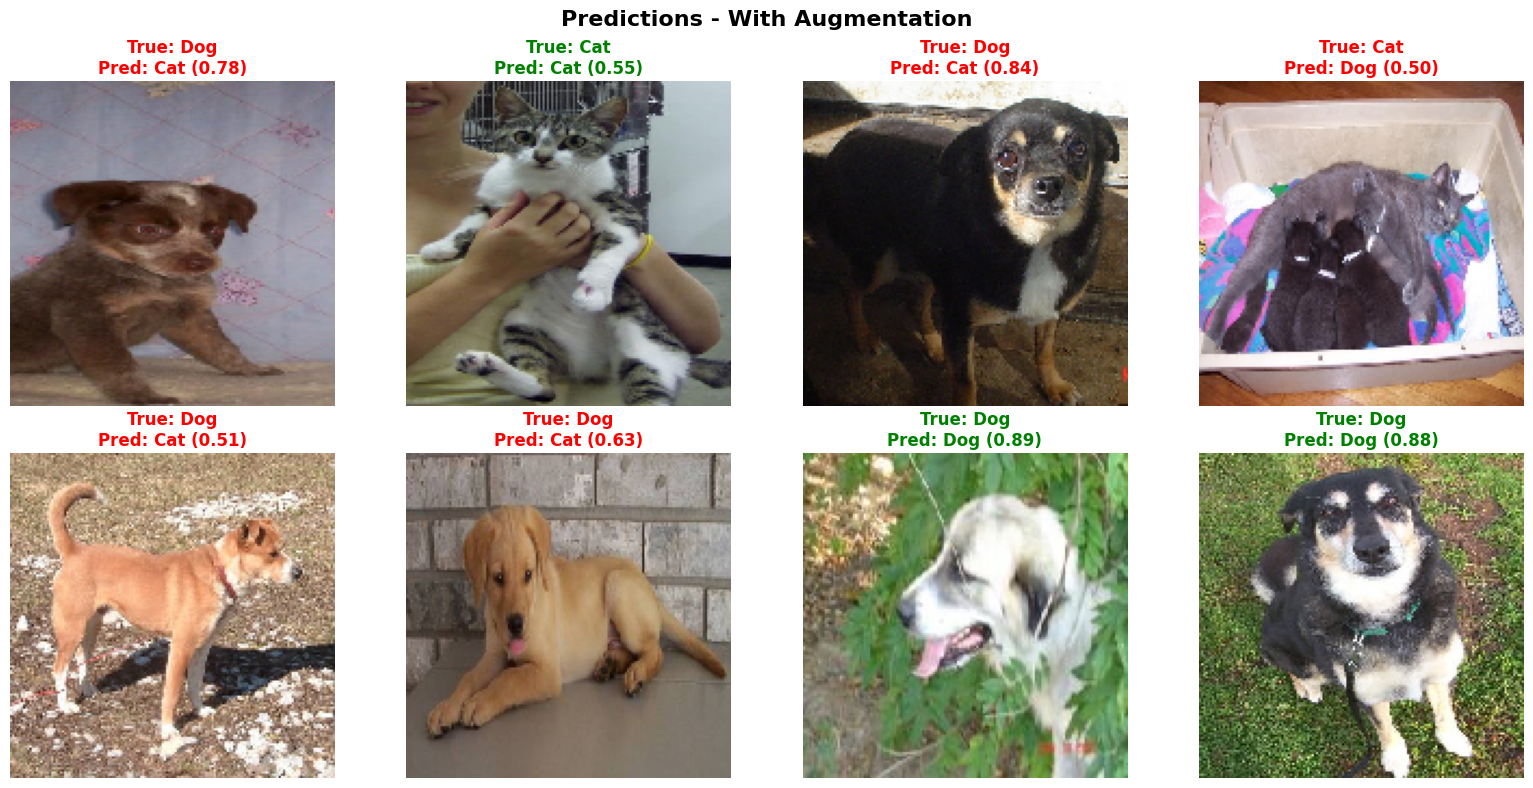

In [14]:
# Prediction Visualization
def predict_and_display(model, generator, model_name, num_images=8):
    """Display predictions for sample images"""
    generator.reset()
    batch_images, batch_labels = next(generator)
    
    predictions = model.predict(batch_images[:num_images])
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    class_names = {0: 'Cat', 1: 'Dog'}  # Assuming cats=0, dogs=1
    
    for i in range(num_images):
        axes[i].imshow(batch_images[i])
        
        predicted_class = 1 if predictions[i][0] > 0.5 else 0
        true_class = int(batch_labels[i])
        confidence = predictions[i][0] if predicted_class == 1 else (1 - predictions[i][0])
        
        # Color coding: green for correct, red for incorrect
        color = 'green' if predicted_class == true_class else 'red'
        
        axes[i].set_title(f'True: {class_names[true_class]}\n'
                         f'Pred: {class_names[predicted_class]} ({confidence:.2f})',
                         color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle(f'Predictions - {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Display predictions for both models
print("Sample Predictions - Model WITHOUT Augmentation:")
predict_and_display(model_no_aug, test_generator, "No Augmentation")

test_generator.reset()
print("\nSample Predictions - Model WITH Augmentation:")
predict_and_display(model_with_aug, test_generator, "With Augmentation")

In [15]:
# Summary and Conclusions
print("="*60)
print("                    EXPERIMENT SUMMARY")
print("="*60)

print(f"\n📊 Dataset Information:")
print(f"   • Total images: {len(df):,}")
print(f"   • Training samples: {len(train_df):,}")
print(f"   • Validation samples: {len(val_df):,}")
print(f"   • Test samples: {len(test_df):,}")

print(f"\n🏗️ Model Architecture:")
print(f"   • Input size: {IMG_HEIGHT}x{IMG_WIDTH}x3")
print(f"   • 4 Convolutional blocks with MaxPooling")
print(f"   • Dropout layer (0.5)")
print(f"   • Dense layers: 512 → 1 (sigmoid)")
print(f"   • Total parameters: {model_no_aug.count_params():,}")

print(f"\n🎯 Final Test Results:")
print(f"   • Without Augmentation: {test_acc_no_aug:.4f} ({test_acc_no_aug*100:.2f}%)")
print(f"   • With Augmentation:    {test_acc_with_aug:.4f} ({test_acc_with_aug*100:.2f}%)")
print(f"   • Improvement:          {accuracy_improvement:+.2f}%")

print(f"\n🔍 Key Observations:")
if test_acc_with_aug > test_acc_no_aug:
    print("   ✅ Data augmentation improved model generalization")
    print("   ✅ Reduced overfitting through synthetic data diversity")
    print("   ✅ Better performance on unseen test data")
else:
    print("   ⚠️  Data augmentation did not improve performance")
    print("   📝 This could be due to:")
    print("      • Sufficient original dataset size")
    print("      • Aggressive augmentation parameters")
    print("      • Model architecture limitations")

print(f"\n💡 Data Augmentation Techniques Used:")
print("   • Rotation (±20°)")
print("   • Width/Height shift (±20%)")
print("   • Shear transformation (20%)")
print("   • Zoom (±20%)")
print("   • Horizontal flip")
print("   • Nearest neighbor fill")

print(f"\n🎉 Experiment completed successfully!")
print("="*60)

                    EXPERIMENT SUMMARY

📊 Dataset Information:
   • Total images: 24,998
   • Training samples: 17,498
   • Validation samples: 3,750
   • Test samples: 3,750

🏗️ Model Architecture:
   • Input size: 150x150x3
   • 4 Convolutional blocks with MaxPooling
   • Dropout layer (0.5)
   • Dense layers: 512 → 1 (sigmoid)
   • Total parameters: 3,453,121

🎯 Final Test Results:
   • Without Augmentation: 0.8669 (86.69%)
   • With Augmentation:    0.6045 (60.45%)
   • Improvement:          -26.24%

🔍 Key Observations:
   ⚠️  Data augmentation did not improve performance
   📝 This could be due to:
      • Sufficient original dataset size
      • Aggressive augmentation parameters
      • Model architecture limitations

💡 Data Augmentation Techniques Used:
   • Rotation (±20°)
   • Width/Height shift (±20%)
   • Shear transformation (20%)
   • Zoom (±20%)
   • Horizontal flip
   • Nearest neighbor fill

🎉 Experiment completed successfully!
